In [1]:
import pandas as pd
import numpy as np
import re

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

import geopandas as gpd
import json
from shapely.geometry import Polygon, mapping
import folium
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

print("Packages imported")

Packages imported


## Collecting data about Moscow's parks

Download data from wikipidea link *https://ru.wikipedia.org/wiki/%D0%A1%D0%B0%D0%B4%D1%8B_%D0%B8_%D0%BF%D0%B0%D1%80%D0%BA%D0%B8_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B*. We should get first 9 tables with informaion about Moscow's Parks.

In [2]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%B0%D0%B4%D1%8B_%D0%B8_%D0%BF%D0%B0%D1%80%D0%BA%D0%B8_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B'

In [3]:
html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

In [4]:
tables = soup.find_all('table')[0:9]
print('Tables count: ',len(tables))

Tables count:  9


In [5]:
#find all table rows with information
trs=[];
for table in tables:    
    for tr in table.find_all('tr'):
        tds=[]
        for td in tr.find_all('td'):
            tds.append(td)
        trs.append(tds)        

In [6]:
#drop empty, it's beacuse of first row get tag <tr>, not <td> as another
trs_not_empty = [x for x in trs if x != []]

In [7]:
#drop data without links
trs=[];
for tr in trs_not_empty:
    tds=[]        
    tds.append(tr[2].text.replace('\n',''))
    tds.append(tr[1].text.replace('\n',''))
    link='';
    if(len(tr[1].find_all('a')) != 0):
        link = 'https://ru.wikipedia.org/'+tr[1].find_all('a')[0].get('href');    
    tds.append(link)
    tds.append(tr[3].text.replace('\n',''))
    trs.append(tds)

In [8]:
#create df_parks
df_parks = pd.DataFrame(data = trs, columns=["name","park_name","park_link","sq"])
print (df_parks.shape)
df_parks.head()

(123, 4)


name                park_name  \
0   Тверской            Тайницкий сад   
1   Тверской      Александровский сад   
2  Басманный          Сад им. Баумана   
3  Басманный  Сады Военного госпиталя   
4  Басманный          Милютинский сад   

                                           park_link    sq  
0  https://ru.wikipedia.org//wiki/%D0%A2%D0%B0%D0...   5,1  
1  https://ru.wikipedia.org//wiki/%D0%90%D0%BB%D0...  9,54  
2  https://ru.wikipedia.org//wiki/%D0%A1%D0%B0%D0...  4,95  
3  https://ru.wikipedia.org//w/index.php?title=%D...  16,5  
4  https://ru.wikipedia.org//wiki/%D0%9C%D0%B8%D0...  0,91

In [9]:
#drop rows without links
df_parks = df_parks[~df_parks.park_link.str.contains('redlink=1')]
df_parks = df_parks[~(df_parks.park_link == '')]
df_parks.shape
df_parks.head()

name            park_name  \
0   Тверской        Тайницкий сад   
1   Тверской  Александровский сад   
2  Басманный      Сад им. Баумана   
4  Басманный      Милютинский сад   
5  Басманный      Морозовский сад   

                                           park_link    sq  
0  https://ru.wikipedia.org//wiki/%D0%A2%D0%B0%D0...   5,1  
1  https://ru.wikipedia.org//wiki/%D0%90%D0%BB%D0...  9,54  
2  https://ru.wikipedia.org//wiki/%D0%A1%D0%B0%D0...  4,95  
4  https://ru.wikipedia.org//wiki/%D0%9C%D0%B8%D0...  0,91  
5  https://ru.wikipedia.org//wiki/%D0%9C%D0%BE%D1...  0,46

We've got link for detail information about all parks, and now, we should add new column to df_parks "park_lat", "park_long"

In [10]:
def getCoords(url):
    lat ='';
    long='';
    html_doc = requests.get(url).text;
    soup = BeautifulSoup(html_doc, 'html.parser');
    elem = soup.find_all("a", {"class": "mw-kartographer-maplink"});
    if (elem != []):
        lat = elem[0]["data-lat"];
        long = elem[0]["data-lon"];    
    return lat, long;

In [11]:
lats=[];
longs=[];
for url in df_parks["park_link"]:
    lat,long = getCoords(url);
    lats.append(lat);
    longs.append(long);
print("Done!")

Done!


In [12]:
df_parks["park_lat"] = lats;
df_parks["park_long"] = longs;
print(df_parks.shape)
df_parks.head()

(118, 6)


name            park_name  \
0   Тверской        Тайницкий сад   
1   Тверской  Александровский сад   
2  Басманный      Сад им. Баумана   
4  Басманный      Милютинский сад   
5  Басманный      Морозовский сад   

                                           park_link    sq    park_lat  \
0  https://ru.wikipedia.org//wiki/%D0%A2%D0%B0%D0...   5,1     55.7503   
1  https://ru.wikipedia.org//wiki/%D0%90%D0%BB%D0...  9,54   55.752345   
2  https://ru.wikipedia.org//wiki/%D0%A1%D0%B0%D0...  4,95     55.7675   
4  https://ru.wikipedia.org//wiki/%D0%9C%D0%B8%D0...  0,91    55.75611   
5  https://ru.wikipedia.org//wiki/%D0%9C%D0%BE%D1...  0,46  55.7554361   

    park_long  
0     37.6206  
1   37.613701  
2    37.65889  
4    37.64667  
5  37.6435472

In [13]:
df_parks = df_parks[~(df_parks.park_lat == '')]
print (df_parks.shape)
df_parks

(114, 6)


name                          park_name  \
0                                 Тверской                      Тайницкий сад   
1                                 Тверской                Александровский сад   
2                                Басманный                    Сад им. Баумана   
4                                Басманный                    Милютинский сад   
5                                Басманный                    Морозовский сад   
6                                Басманный  Парк в Спасоглинищевском переулке   
7                                Мещанский                  Фестивальный парк   
8                                Мещанский                Екатерининский парк   
9                                Мещанский               Екатерининский сквер   
10                               Мещанский                 Аптекарский огород   
11                             Пресненский                     Красная Пресня   
12                             Пресненский                     Сад «Аквариум»   
13                             Пресненский         Детский парк «Пресненский»   
14                             Пресненский           Сквер «Патриаршие пруды»   
15                             Пресненский                 Московский зоопарк   
16                             Пресненский        Парк Декабрьского восстания   
17                               Таганский                     Таганский парк   
18                                Тверской                        Сад Эрмитаж   
21                               Хамовники               Сквер Девичьего поля   
23                                Якиманка                      Парк искусств   
24                                Якиманка         Парк культуры им. Горького   
25                                Якиманка                      Нескучный сад   
26                                Аэропорт                    Петровский парк   
27                         Бескудниковский     Парк имени Святослава Фёдорова   
28                              Войковский              Парк имени Воровского   
29                      Восточное Дегунино              Парк «Северные Дубки»   
30                             Дмитровский                 Парк «Дмитровский»   
31                             Дмитровский                Парк «Вагоноремонт»   
32                             Дмитровский                    Ангарские пруды   
33                            Левобережный     Парк Северного речного вокзала   
..                                     ...                                ...   
92                         Северное Бутово                 Бутовский лесопарк   
93                             Тёплый Стан             Теплостанский лесопарк   
94                               Черёмушки               Черёмушки-Знаменское   
95                                 Ясенево                     Битцевский лес   
96                                 Ясенево               Голубинский лесопарк   
97                                 Ясенево                     Малое Голубино   
98                                 Ясенево       Парк 30-летия района Ясенево   
99   Тропарёво-Никулино, Обручевский район              Юго-Западный лесопарк   
100                                Ясенево                Ясеневский лесопарк   
101                              Черёмушки               Парк 70-летия Победы   
102                           Дорогомилово                        Парк Победы   
103                             Крылатское                   Крылатские холмы   
104                       Ново-Переделкино                    Чоботовский лес   
105    Очаково-Матвеевское, Фили-Давыдково                    Матвеевский лес   
106                                Раменки              Парк 50-летия Октября   
107                                Раменки                     Воробьёвы горы   
108                                Раменки               Ботанический сад МГУ   
109                     Тропарёво-Никулино                    Парк Шк

Save to csv file information about parks

In [14]:
df_parks.to_csv (r'parks_dataframe.csv', index = None, header=True)

In [15]:
df_parks = pd.read_csv('parks_dataframe.csv')
print(df_parks.shape)
df_parks.head()

(114, 6)


name            park_name  \
0   Тверской        Тайницкий сад   
1   Тверской  Александровский сад   
2  Басманный      Сад им. Баумана   
3  Басманный      Милютинский сад   
4  Басманный      Морозовский сад   

                                           park_link    sq   park_lat  \
0  https://ru.wikipedia.org//wiki/%D0%A2%D0%B0%D0...   5,1  55.750300   
1  https://ru.wikipedia.org//wiki/%D0%90%D0%BB%D0...  9,54  55.752345   
2  https://ru.wikipedia.org//wiki/%D0%A1%D0%B0%D0...  4,95  55.767500   
3  https://ru.wikipedia.org//wiki/%D0%9C%D0%B8%D0...  0,91  55.756110   
4  https://ru.wikipedia.org//wiki/%D0%9C%D0%BE%D1...  0,46  55.755436   

   park_long  
0  37.620600  
1  37.613701  
2  37.658890  
3  37.646670  
4  37.643547

Let's display **df_parks** with *folium*

In [16]:
# init map
m = folium.Map(location=[55.764414, 37.647859], height=500, zoom_start = 9)

#add markers
for name,lat,long in zip(df_parks.park_name, df_parks.park_lat, df_parks.park_long):
    folium.Marker(
        [lat, long],
        popup='<i>{}</i>'.format(name)
    ).add_to(m)

m

## Collecting data by using Foursquare API

Define Foursquare Credentials and Version

In [17]:
CLIENT_ID = 'Y3FU1X0JU1Z2YKUNLTUCCWH5K0DMDA0AZQAWWMFM4I3XIOZI' # your Foursquare ID
CLIENT_SECRET = '0G02XW3JUA4XIBNNBB5N1G4QUXC1MY3QZGT21DGJITJ2YYY3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('LIMIT = ', LIMIT)
print('radius = ', radius)

Your credentails:
CLIENT_ID: Y3FU1X0JU1Z2YKUNLTUCCWH5K0DMDA0AZQAWWMFM4I3XIOZI
CLIENT_SECRET:0G02XW3JUA4XIBNNBB5N1G4QUXC1MY3QZGT21DGJITJ2YYY3
LIMIT =  100
radius =  500


Let's create a function to repeat the same process to all Moscow's regions.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes), total=len(names)):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
#         print(url)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['park_name', 
                  'park_lat', 
                  'park_long', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
moscow_venues = getNearbyVenues(df_parks.park_name, df_parks.park_lat, df_parks.park_long)

100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [00:55<00:00,  2.43it/s]


In [20]:
print(moscow_venues.shape)
moscow_venues.head()

(2295, 7)


park_name  park_lat  park_long  \
0  Тайницкий сад   55.7503    37.6206   
1  Тайницкий сад   55.7503    37.6206   
2  Тайницкий сад   55.7503    37.6206   
3  Тайницкий сад   55.7503    37.6206   
4  Тайницкий сад   55.7503    37.6206   

                                             Venue  Venue Latitude  \
0              Cathedral Square (Соборная площадь)       55.750677   
1                               Васильевский Спуск       55.751502   
2                             The Kremlin (Кремль)       55.751999   
3  St. Basil's Cathedral (Храм Василия Блаженного)       55.752524   
4                     Red Square (Красная площадь)       55.753595   

   Venue Longitude       Venue Category  
0        37.617442                Plaza  
1        37.623332                Plaza  
2        37.617734  Government Building  
3        37.623110               Church  
4        37.621031                Plaza

In [21]:
moscow_venues.groupby('park_name').count()

park_lat  park_long  Venue  \
park_name                                                                     
Александровский сад                                    45         45     45   
Ангарские пруды                                        17         17     17   
Аннинский лесопарк                                      7          7      7   
Аптекарский огород                                     42         42     42   
Аршиновский парк                                        6          6      6   
Бабушкинский парк                                      25         25     25   
Бирюлёвский дендрарий                                   4          4      4   
Битцевский лес                                          2          2      2   
Борисовские пруды                                       7          7      7   
Ботанический сад МГУ                                    4          4      4   
Братеевская пойма                                       2          2      2   
Братеевский каскадный парк                              4          4      4   
Братиславский парк                                     23         23     23   
Бутовский лесопарк                                      1          1      1   
Воробьёвы горы                                         18         18     18   
Выставка достижений народного хозяйства                49         49     49   
Главный ботанический сад имени Н. В. Цицина РАН         2          2      2   
Голубинский лесопарк                                    4          4      4   
Гольяновский парк                                       7          7      7   
Грачёвский парк                                        18         18     18   
Детский парк «Пресненский»                             43         43     43   
Дюссельдорфский парк                                   10         10     10   
Екатерининский парк                                    26         26     26   
Екатерининский сквер                                   33         33     33   
Измайловский парк                                       6          6      6   
Коломенское                                            32         32     32   
Коробковский сад                                        7          7      7   
Косинский парк                                          3          3      3   
Красная Пресня                                         55         55     55   
Крылатские холмы                                        6          6      6   
...                                                   ...        ...    ...   
Перовский парк                                         15         15     15   
Петровский парк                                        18         18     18   
Покровское-Стрешнево                                    4          4      4   
Природный парк «Куркино»                                4          4      4   
Пруд «Садки»                                           24         24     24   
Сад «Аквариум»                                         90         90     90   
Сад Эрмитаж                                            70         70     70   
Сад им. Баумана                                        75         75     75   
Серебряный Бор                                          5          5      5   
Сквер «Патриаршие пруды»                               83         83     83   
Сквер Девичьего поля                                   25         25     25   
Сосенки                                                15         15     15   
Сходненская чаша                                        3          3      3   
Таганский парк                                         71         71     71   
Тайницкий сад                                          48         48     48   
Таллинский парк                                        13         13     13   
Теплостанский лесопарк                                  3          3      3   
Терлецкий парк                                          5          5      5   
Тимирязевский парк  

Let's find out how many unique categories can be curated from all the returned venues.

In [22]:
print('There are {} uniques categories.'.format(len(moscow_venues['Venue Category'].unique())))

There are 311 uniques categories.


### Analyze Each Park

In [23]:
# one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues[['Venue Category']], prefix="", prefix_sep="")

# add park_name column back to dataframe
moscow_onehot['park_name'] = moscow_venues['park_name'] 

# move park_name column to the first column
fixed_columns = [moscow_onehot.columns[-1]] + list(moscow_onehot.columns[:-1])
moscow_onehot = moscow_onehot[fixed_columns]

moscow_onehot.head()

park_name  ATM  Accessories Store  Adult Boutique  American Restaurant  \
0  Тайницкий сад    0                  0               0                    0   
1  Тайницкий сад    0                  0               0                    0   
2  Тайницкий сад    0                  0               0                    0   
3  Тайницкий сад    0                  0               0                    0   
4  Тайницкий сад    0                  0               0                    0   

   Amphitheater  Antique Shop  Aquarium  Arcade  Art Gallery  ...  \
0             0             0         0       0            0  ...   
1             0             0         0       0            0  ...   
2             0             0         0       0            0  ...   
3             0             0         0       0            0  ...   
4             0             0         0       0            0  ...   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Volleyball Court  \
0                              0                      0                 0   
1                              0                      0                 0   
2                              0                      0                 0   
3                              0                      0                 0   
4                              0                      0                 0   

   Watch Shop  Water Park  Wine Bar  Wine Shop  Yoga Studio  Zoo  Zoo Exhibit  
0           0           0         0          0            0    0            0  
1           0           0         0          0            0    0            0  
2           0           0         0          0            0    0            0  
3           0           0         0          0            0    0            0  
4           0           0         0          0            0    0            0  

[5 rows x 312 columns]

And let's examine the new dataframe size.

In [24]:
moscow_onehot.shape

(2295, 312)

In [25]:
moscow_grouped = moscow_onehot.groupby('park_name').mean().reset_index()
moscow_grouped.head()

park_name  ATM  Accessories Store  Adult Boutique  \
0  Александровский сад  0.0                0.0             0.0   
1      Ангарские пруды  0.0                0.0             0.0   
2   Аннинский лесопарк  0.0                0.0             0.0   
3   Аптекарский огород  0.0                0.0             0.0   
4     Аршиновский парк  0.0                0.0             0.0   

   American Restaurant  Amphitheater  Antique Shop  Aquarium  Arcade  \
0                  0.0      0.000000           0.0       0.0     0.0   
1                  0.0      0.058824           0.0       0.0     0.0   
2                  0.0      0.000000           0.0       0.0     0.0   
3                  0.0      0.000000           0.0       0.0     0.0   
4                  0.0      0.000000           0.0       0.0     0.0   

   Art Gallery  ...  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0     0.022222  ...                       0.022222                0.00000   
1     0.000000  ...                       0.000000                0.00000   
2     0.000000  ...                       0.000000                0.00000   
3     0.000000  ...                       0.023810                0.02381   
4     0.000000  ...                       0.000000                0.00000   

   Volleyball Court  Watch Shop  Water Park  Wine Bar  Wine Shop  Yoga Studio  \
0               0.0         0.0         0.0       0.0        0.0      0.00000   
1               0.0         0.0         0.0       0.0        0.0      0.00000   
2               0.0         0.0         0.0       0.0        0.0      0.00000   
3               0.0         0.0         0.0       0.0        0.0      0.02381   
4               0.0         0.0         0.0       0.0        0.0      0.00000   

   Zoo  Zoo Exhibit  
0  0.0          0.0  
1  0.0          0.0  
2  0.0          0.0  
3  0.0          0.0  
4  0.0          0.0  

[5 rows x 312 columns]

Let's confirm the new size.

In [26]:
moscow_grouped.shape

(111, 312)

Let's print top 10 parks along with the top 5 most common venues. (It's just for stop spamming to notebook)

In [27]:
top_park = 10
num_top_venues = 5

for park in moscow_grouped['park_name'].head(top_park):
    print("----"+str(park)+"----")
    temp = moscow_grouped[moscow_grouped['park_name'] == park].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Александровский сад----
            venue  freq
0           Plaza  0.09
1  History Museum  0.09
2          Palace  0.04
3  Cosmetics Shop  0.04
4           Hotel  0.04


----Ангарские пруды----
              venue  freq
0       Supermarket  0.18
1          Bus Stop  0.12
2  Basketball Court  0.06
3         Nightclub  0.06
4           Brewery  0.06


----Аннинский лесопарк----
                  venue  freq
0  Fast Food Restaurant  0.29
1            Shoe Store  0.14
2                  Park  0.14
3                 Diner  0.14
4       Motorcycle Shop  0.14


----Аптекарский огород----
                        venue  freq
0                      Bakery  0.05
1                 Coffee Shop  0.05
2   Middle Eastern Restaurant  0.05
3                       Hotel  0.05
4  Modern European Restaurant  0.05


----Аршиновский парк----
          venue  freq
0   Supermarket  0.33
1    Playground  0.17
2  Dessert Shop  0.17
3          Park  0.17
4           Gym  0.17


----Бабушкинский парк----
     

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['park_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
moscow_parks_sorted = pd.DataFrame(columns=columns)
moscow_parks_sorted['park_name'] = moscow_grouped['park_name']

for ind in np.arange(moscow_grouped.shape[0]):
    moscow_parks_sorted.iloc[ind, 1:] = return_most_common_venues(moscow_grouped.iloc[ind, :], num_top_venues)

moscow_parks_sorted

park_name 1st Most Common Venue  \
0                                Александровский сад        History Museum   
1                                    Ангарские пруды           Supermarket   
2                                 Аннинский лесопарк  Fast Food Restaurant   
3                                 Аптекарский огород      Botanical Garden   
4                                   Аршиновский парк           Supermarket   
5                                  Бабушкинский парк           Supermarket   
6                              Бирюлёвский дендрарий                Garden   
7                                     Битцевский лес                  Park   
8                                  Борисовские пруды      Basketball Court   
9                               Ботанический сад МГУ      Botanical Garden   
10                                 Братеевская пойма                  Café   
11                        Братеевский каскадный парк   Japanese Restaurant   
12                                Братиславский парк           Supermarket   
13                                Бутовский лесопарк    Athletics & Sports   
14                                    Воробьёвы горы             Cable Car   
15           Выставка достижений народного хозяйства  Fast Food Restaurant   
16   Главный ботанический сад имени Н. В. Цицина РАН      Botanical Garden   
17                              Голубинский лесопарк                   ATM   
18                                 Гольяновский парк     Convenience Store   
19                                   Грачёвский парк              Bus Stop   
20                        Детский парк «Пресненский»                  Café   
21                              Дюссельдорфский парк             Racetrack   
22                               Екатерининский парк                  Pool   
23                              Екатерининский сквер                  Park   
24                                 Измайловский парк                  Lake   
25                                       Коломенское        History Museum   
26                                  Коробковский сад           Coffee Shop   
27                                    Косинский парк         Auto Workshop   
28                                    Красная Пресня           Coffee Shop   
29                                  Крылатские холмы         Auto Workshop   
..                                               ...                   ...   
81                                    Перовский парк           Supermarket   
82                                   Петровский парк           Coffee Shop   
83                              Покровское-Стрешнево            Playground   
84                          Природный парк «Куркино»                  Park   
85                                      Пруд «Садки»  Gym / Fitness Center   
86                                    Сад «Аквариум»           Coffee Shop   
87                                       Сад Эрмитаж               Theater   
88                                   Сад им. Баумана           Coffee Shop   
89                                    Серебряный Бор          Nudist Beach   
90                          Сквер «Патриаршие пруды»              Wine Bar   
91                              Сквер Девичьего поля     Convenience Store   
92                                           Сосенки              Bus Stop   
93                                  Сходненская чаша                  Park   
94                                    Таганский парк           Coffee Shop   
95                                     Тайницкий сад              Boutique   
96                                   Таллинский парк    Salon / Barbershop   
97                            Теплостанский лесопарк       Nature Preserve   
98                                    Терлецкий парк                  Lake   
99                                Тимирязевский парк                  Park   
100                                Тропарёвский парк             

## Cluster Parks

Run k-means to cluster the neighborhood into 5 clusters.

In [30]:
from sklearn.cluster import KMeans

kclusters = 5

moscow_grouped_clustering = moscow_grouped.drop('park_name', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_clustering)

len(kmeans.labels_)

111

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [31]:
moscow_parks_sorted['Cluster Labels'] = kmeans.labels_
moscow_parks_sorted.head()

park_name 1st Most Common Venue 2nd Most Common Venue  \
0  Александровский сад        History Museum                 Plaza   
1      Ангарские пруды           Supermarket              Bus Stop   
2   Аннинский лесопарк  Fast Food Restaurant                 Hotel   
3   Аптекарский огород      Botanical Garden                Bakery   
4     Аршиновский парк           Supermarket                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Museum            Shoe Store                 Hotel   
1                Notary             Pet Store              Pharmacy   
2       Motorcycle Shop                  Park                 Diner   
3           Coffee Shop  Caucasian Restaurant                   Spa   
4                   Gym          Dessert Shop            Playground   

        6th Most Common Venue      7th Most Common Venue  \
0                    Boutique             Science Museum   
1                        Park                     Garden   
2                  Shoe Store                Film Studio   
3  Modern European Restaurant  Middle Eastern Restaurant   
4                 Zoo Exhibit                 Food Stand   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
0    Russian Restaurant        Cosmetics Shop                 Palace   
1             Nightclub        Cosmetics Shop           Amphitheater   
2           Flea Market           Flower Shop      Food & Drink Shop   
3          Dance Studio                 Hotel  Vietnamese Restaurant   
4           Film Studio           Flea Market            Flower Shop   

   Cluster Labels  
0               1  
1               0  
2               1  
3               1  
4               0

In [32]:
moscow_merged = df_parks.merge(moscow_parks_sorted, left_on='park_name', right_on='park_name', how='left')
moscow_merged = moscow_merged.dropna()
moscow_merged['Cluster Labels'] = moscow_merged['Cluster Labels'].astype('int')
print(moscow_merged.shape)
moscow_merged.head()

(107, 17)


name            park_name  \
0   Тверской        Тайницкий сад   
1   Тверской  Александровский сад   
2  Басманный      Сад им. Баумана   
3  Басманный      Милютинский сад   
4  Басманный      Морозовский сад   

                                           park_link    sq   park_lat  \
0  https://ru.wikipedia.org//wiki/%D0%A2%D0%B0%D0...   5,1  55.750300   
1  https://ru.wikipedia.org//wiki/%D0%90%D0%BB%D0...  9,54  55.752345   
2  https://ru.wikipedia.org//wiki/%D0%A1%D0%B0%D0...  4,95  55.767500   
3  https://ru.wikipedia.org//wiki/%D0%9C%D0%B8%D0...  0,91  55.756110   
4  https://ru.wikipedia.org//wiki/%D0%9C%D0%BE%D1...  0,46  55.755436   

   park_long 1st Most Common Venue 2nd Most Common Venue  \
0  37.620600              Boutique        History Museum   
1  37.613701        History Museum                 Plaza   
2  37.658890           Coffee Shop  Caucasian Restaurant   
3  37.646670           Coffee Shop             Bookstore   
4  37.643547           Coffee Shop           Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop                 Plaza         Historic Site   
1                Museum            Shoe Store                 Hotel   
2    Italian Restaurant                  Café                Hostel   
3                  Café         Historic Site           Yoga Studio   
4                  Café             Bookstore           Art Gallery   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                Palace         Jewelry Store              Fountain   
1              Boutique        Science Museum    Russian Restaurant   
2         Historic Site                Bakery           Music Venue   
3              Beer Bar                 Plaza           Art Gallery   
4                Bakery           Yoga Studio              Wine Bar   

  9th Most Common Venue      10th Most Common Venue  Cluster Labels  
0                   Bar           Electronics Store               1  
1        Cosmetics Shop                      Palace               1  
2            Restaurant                 Supermarket               1  
3    Miscellaneous Shop  Modern European Restaurant               1  
4             Gastropub        Caucasian Restaurant               1

Finally, let's visualize the resulting clusters.

In [168]:
# create map
map_clusters = folium.Map(location=[55.764414, 37.647859],  zoom_start = 9.5)

# set color scheme for the clusters
# x = np.arange(kclusters)
# ys = [i+x+(i*x)**2 for i in range(kclusters)]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
# markers_colors = []
# for lat, lon, poi, cluster in zip(moscow_merged['park_lat'], moscow_merged['park_long'], moscow_merged['park_name'], moscow_merged['Cluster Labels']):
#     label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
#     folium.CircleMarker(
#         [lat, lon],
#         radius=5,
#         popup=label,
#         color=rainbow[cluster-1],
#         fill=True,
#         fill_color=rainbow[cluster-1],
#         fill_opacity=0.7).add_to(map_clusters)
    
#style marker
#        'cadetblue', 'green', 'darkblue', 'white', 'gray', 'purple', 'lightgreen', 'darkred', 'beige', 'red', 'darkgreen', 'lightgrayblack', 'blue', 'pink', 'lightblue', 'darkpurple', 'orange', 'lightred'
markers_colors = ['darkgreen','lightgreen','purple', 'lightblue','blue']
for lat, lon, poi, cluster in zip(moscow_merged['park_lat'], moscow_merged['park_long'], moscow_merged['park_name'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color=markers_colors[cluster], icon='fa-pagelines')
    ).add_to(map_clusters)

map_clusters

In [34]:
map_clusters.save('map_cluster.html')

In [162]:
# help(folium.Icon)

## Examine Clusters

Cluster 1

In [37]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 0, moscow_merged.columns[[0] + list(range(4, moscow_merged.shape[1] - 1))]]

name   park_lat  park_long  \
25               Восточное Дегунино  55.888890  37.565000   
28                      Дмитровский  55.880000  37.531110   
34                          Ховрино  55.865800  37.506700   
37                         Бибирево  55.900000  37.600000   
48                 Лосиноостровский  55.875000  37.684440   
49                         Бибирево  55.895310  37.621740   
56                           Перово  55.743122  37.773036   
63                          Марьино  55.653864  37.752589   
68                        Печатники  55.653444  37.677389   
74   Братеево, Москворечье-Сабурово  55.637800  37.734400   
79                         Царицыно  55.620600  37.654200   
81                         Царицыно  55.627200  37.660700   
83                         Котловка  55.668100  37.601700   
86                        Черёмушки  55.676986  37.585355   
88                          Ясенево  55.608330  37.508330   
89                          Ясенево  55.608330  37.508330   
109    Покровское-Стрешнево, Щукино  55.822200  37.475000   

    1st Most Common Venue 2nd Most Common Venue     3rd Most Common Venue  \
25          Auto Workshop              Gym Pool               Supermarket   
28            Supermarket              Bus Stop                    Notary   
34               Bus Stop           Supermarket                      Café   
37                   Park                   Bar                      Café   
48             Restaurant           Supermarket                  Bus Stop   
49               Bus Stop           Supermarket                Restaurant   
56            Supermarket     Convenience Store            Cosmetics Shop   
63            Supermarket           Pizza Place                       Spa   
68              Racetrack                  Park                  Bus Stop   
74    Japanese Restaurant                  Park         Convenience Store   
79            Supermarket                  Park                       Gym   
81               Bus Stop         Grocery Store                 BBQ Joint   
83             Restaurant               Dog Run                  Bus Stop   
86    Arts & Crafts Store           Sports Club         Convenience Store   
88                    ATM           Supermarket                  Bus Stop   
89                    ATM           Supermarket                  Bus Stop   
109            Playground                  Park  Bike Rental / Bike Share   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
25       Department Store          Soccer Field                  Park   
28              Pet Store              Pharmacy                  Park   
34              Bookstore     Electronics Store               Brewery   
37         Cosmetics Shop           Supermarket              Bus Stop   
48             Public Art                  Park              Pharmacy   
49                   Park   Japanese Restaurant              Bus Line   
56         Soccer Stadium                  Park            Skate Park   
63           Skating Rink        Farmers Market               Theater   
68            Zoo Exhibit            Food Stand           Film Studio   
74            Supermarket      Football Stadium           Flea Market   
79           Dessert Shop            Playground           Zoo Exhibit   
81              Pet Store           Gas Station               Dog Run   
83            Music Venue           Supermarket                  Park   
86               Bus Stop          Tram Station            Food Truck   
88                  Diner      Football Stadium           Flea Market   
89                  Diner      Football Stadium           Flea Market   
109           Zoo Exhibit            Food Truck           Film Studio   

           7th Most Common Venue        8th Most Common Venue  \
25                   Pizza Place                      Stadium   
28                        Garden                    Nightclub   
34                    Shoe Store   

Cluster 2

In [38]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 1, moscow_merged.columns[[0] + list(range(4, moscow_merged.shape[1] - 1))]]

name   park_lat  park_long  \
0                                           Тверской  55.750300  37.620600   
1                                           Тверской  55.752345  37.613701   
2                                          Басманный  55.767500  37.658890   
3                                          Басманный  55.756110  37.646670   
4                                          Басманный  55.755436  37.643547   
5                                          Басманный  55.755830  37.636390   
6                                          Мещанский  55.790700  37.619300   
7                                          Мещанский  55.783954  37.621256   
8                                          Мещанский  55.779778  37.618194   
9                                          Мещанский  55.778381  37.635811   
10                                       Пресненский  55.754200  37.552800   
11                                       Пресненский  55.767500  37.595280   
12                                       Пресненский  55.756670  37.573610   
13                                       Пресненский  55.763900  37.591900   
14                                       Пресненский  55.761944  37.577222   
15                                       Пресненский  55.760830  37.560280   
16                                         Таганский  55.737500  37.667200   
17                                          Тверской  55.770781  37.609440   
18                                         Хамовники  55.735830  37.576940   
19                                          Якиманка  55.735554  37.607916   
20                                          Якиманка  55.731169  37.603197   
21                                          Якиманка  55.716110  37.588060   
22                                          Аэропорт  55.793392  37.556206   
23                                   Бескудниковский  55.865000  37.550000   
24                                        Войковский  55.819778  37.501617   
27                                       Дмитровский  55.887780  37.531670   
29                                      Левобережный  55.851597  37.469486   
30                                      Левобережный  55.853060  37.480560   
31                                             Сокол  55.799720  37.512556   
33                                     Тимирязевский  55.820560  37.566390   
..                                               ...        ...        ...   
66                                           Марьино  55.661390  37.755830   
67                                         Печатники  55.683700  37.710000   
69                                      Текстильщики  55.705600  37.733600   
70                                Бирюлёво Восточное  55.596940  37.679440   
72     Бирюлёво Восточное, Орехово-Борисово Северное  55.616110  37.682780   
73                                          Братеево  55.637500  37.779700   
75   Москворечье-Сабурово, Орехово-Борисово Северное  55.631700  37.713600   
76                                 Нагатинский Затон  55.669440  37.668890   
77                                 Нагатинский Затон  55.693900  37.671700   
78                                Нагатино-Садовники  55.661940  37.653890   
80                                   Чертаново Южное  55.580000  37.603610   
82                                          Котловка  55.666900  37.603900   
85                                       Тёплый Стан  55.632748  37.496424   
91             Тропарёво-Никулино, Обручевский район  55.657500  37.503300   
92                                           Ясенево  55.594799  37.524758   
93                                         Черёмушки  55.664700  37.570000   
94                                      Дорогомилово  55.731670  37.506670   
95                                        Крылатское  55.760600  37.424800   
96                                  Ново-Переделкино  55.646400  37.361700   
97               Очаково-Матвеевское, Фили-Давыдково  55.721110  37.48

Cluster 3

In [39]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 2, moscow_merged.columns[[0] + list(range(4, moscow_merged.shape[1] - 1))]]

name   park_lat  park_long 1st Most Common Venue  \
32        Тимирязевский  55.819000  37.545000                  Park   
53              Вешняки  55.731583  37.819836                  Park   
87              Ясенево  55.630000  37.562780                  Park   
102  Тропарёво-Никулино  55.648890  37.459440                  Park   
106             Куркино  55.888610  37.375560                  Park   
113        Южное Тушино  55.844720  37.411390                  Park   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
32                   Lake           Zoo Exhibit            Food Stand   
53            Cheese Shop           Zoo Exhibit        Farmers Market   
87   Other Great Outdoors           Zoo Exhibit            Food Truck   
102     Recreation Center       Nature Preserve                  Lake   
106        Scenic Lookout                  Lake           Zoo Exhibit   
113     Convenience Store           Zoo Exhibit            Food Truck   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
32   Fast Food Restaurant           Film Studio           Flea Market   
53            Film Studio           Flea Market           Flower Shop   
87            Film Studio           Flea Market           Flower Shop   
102            Food Truck           Film Studio           Flea Market   
106            Food Stand  Fast Food Restaurant           Film Studio   
113           Film Studio           Flea Market           Flower Shop   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
32            Flower Shop     Food & Drink Shop             Food Court  
53      Food & Drink Shop            Food Court             Food Stand  
87      Food & Drink Shop            Food Court             Food Stand  
102           Flower Shop     Food & Drink Shop             Food Court  
106           Flea Market           Flower Shop      Food & Drink Shop  
113     Food & Drink Shop            Food Court             Food Stand

Cluster 4

In [40]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 3, moscow_merged.columns[[0] + list(range(4, moscow_merged.shape[1] - 1))]]

name  park_lat  park_long 1st Most Common Venue  \
43  Останкинский   55.8392    37.6008      Botanical Garden   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
43      Football Stadium           Film Studio           Flea Market   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
43           Flower Shop     Food & Drink Shop            Food Court   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
43            Food Stand            Food Truck                 Forest

Cluster 5

In [41]:
moscow_merged.loc[moscow_merged['Cluster Labels'] == 4, moscow_merged.columns[[0] + list(range(4, moscow_merged.shape[1] - 1))]]

name  park_lat  park_long 1st Most Common Venue  \
84  Северное Бутово     55.57      37.53    Athletics & Sports   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
84           Zoo Exhibit    Falafel Restaurant  Fast Food Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
84           Film Studio           Flea Market           Flower Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
84     Food & Drink Shop            Food Court             Food Stand

## Heat map

Starting collecting data of Moscow regions: Downloading data from http://gis-lab.info/qa/moscow-atd.html and **"mo.geojson"** add this file to project. Reading this file by *geopandas*.

In [42]:
mo_gdf = gpd.read_file('mo.geojson')
print('Size: ',mo_gdf.shape)
mo_gdf.head()

Size:  (146, 8)


NAME     OKATO     OKTMO         NAME_AO  OKATO_AO  \
0         Киевский  45298555  45945000        Троицкий  45298000   
1   Филёвский Парк  45268595  45328000        Западный  45268000   
2  Новофёдоровское  45298567  45954000        Троицкий  45298000   
3        Роговское  45298575  45956000        Троицкий  45298000   
4     "Мосрентген"  45297568  45953000  Новомосковский  45297000   

        ABBREV_AO              TYPE_MO  \
0        Троицкий            Поселение   
1             ЗАО  Муниципальный округ   
2        Троицкий            Поселение   
3        Троицкий            Поселение   
4  Новомосковский            Поселение   

                                            geometry  
0  (POLYGON ((36.8031 55.44083, 36.80319 55.4416,...  
1  POLYGON ((37.42765 55.74821, 37.42849 55.74875...  
2  POLYGON ((36.80357 55.45162, 36.80451 55.46551...  
3  POLYGON ((36.93724 55.24139, 36.93726 55.24161...  
4  POLYGON ((37.43956 55.62731, 37.44018 55.63042...

Just for tests we can draw this data by matplotlib.

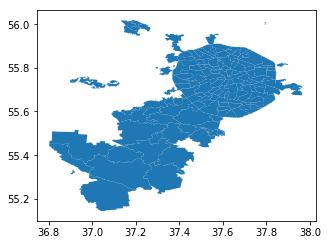

In [43]:
mo_gdf.plot(figsize=[5,5])

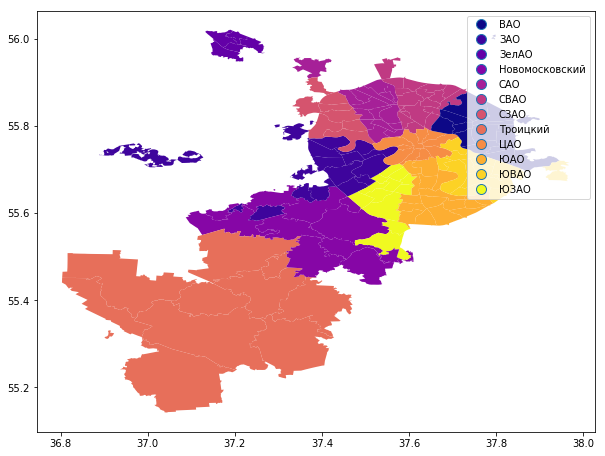

In [44]:
mo_gdf.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[10,10])

The object of the analysis will be the central regions of Moscow (red areas)

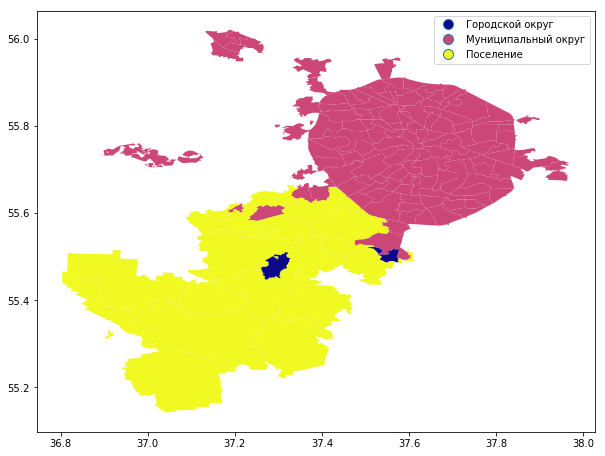

In [45]:
mo_gdf.plot(column = 'TYPE_MO', linewidth=0.5, cmap='plasma', legend=True, figsize=[10,10])

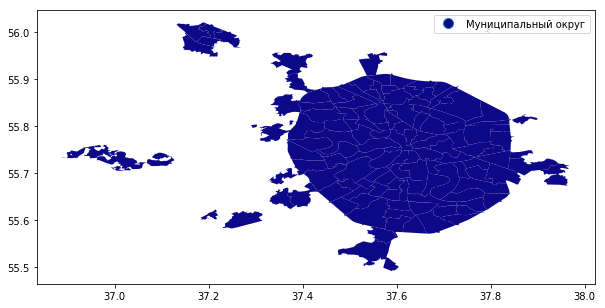

In [46]:
df_central = mo_gdf[mo_gdf.TYPE_MO=="Муниципальный округ"]
df_central.plot(column = 'TYPE_MO', linewidth=0.5, cmap='plasma', legend=True, figsize=[10,10])

Create *df_parks_reg* for visualize.

In [47]:
df_parks_reg = df_central.merge(df_parks, left_on='NAME', right_on='name', how='left')
print(df_parks_reg.shape)
df_parks_reg.head()

(171, 14)


NAME     OKATO     OKTMO         NAME_AO  OKATO_AO ABBREV_AO  \
0  Филёвский Парк  45268595  45328000        Западный  45268000       ЗАО   
1       Матушкино  45272562  45331000  Зеленоградский  45272000     ЗелАО   
2         Внуково  45268552  45317000        Западный  45268000       ЗАО   
3         Савёлки  45272568  45377000  Зеленоградский  45272000     ЗелАО   
4          Силино  45272572  45332000  Зеленоградский  45272000     ЗелАО   

               TYPE_MO                                           geometry  \
0  Муниципальный округ  POLYGON ((37.42765 55.74821, 37.42849 55.74875...   
1  Муниципальный округ  POLYGON ((37.17853 56.00795, 37.18083 56.00825...   
2  Муниципальный округ  (POLYGON ((37.23021 55.58532, 37.23537 55.5865...   
3  Муниципальный округ  POLYGON ((37.20946 56.00083, 37.20975 56.00088...   
4  Муниципальный округ  POLYGON ((37.1316 56.01645, 37.13266 56.01678,...   

             name       park_name  \
0  Филёвский Парк  Филёвский парк   
1             NaN             NaN   
2             NaN             NaN   
3             NaN             NaN   
4             NaN             NaN   

                                           park_link   sq  park_lat  park_long  
0  https://ru.wikipedia.org//wiki/%D0%A4%D0%B8%D0...  280     55.74    37.4619  
1                                                NaN  NaN       NaN        NaN  
2                                                NaN  NaN       NaN        NaN  
3                                                NaN  NaN       NaN        NaN  
4                                                NaN  NaN       NaN        NaN

In [48]:
df_parks_reg[df_parks_reg.park_name.notnull()].shape

(105, 14)

In [49]:
df_grouped_parks_reg = df_parks_reg.groupby(['NAME']).count().iloc[:,:1].reset_index()
df_grouped_parks_reg.columns=["NAME","count_parks"]
df_grouped_parks_reg = df_grouped_parks_reg.merge(df_central, left_on='NAME', right_on='NAME', how='left')
print(df_grouped_parks_reg.shape)
df_grouped_parks_reg.head()

(125, 9)


NAME  count_parks     OKATO     OKTMO           NAME_AO  OKATO_AO  \
0  Академический            1  45293554  45397000      Юго-Западный  45293000   
1   Алексеевский            1  45280552  45349000  Северо-Восточный  45280000   
2   Алтуфьевский            1  45280554  45350000  Северо-Восточный  45280000   
3          Арбат            1  45286552  45374000       Центральный  45286000   
4       Аэропорт            1  45277553  45333000          Северный  45277000   

  ABBREV_AO              TYPE_MO  \
0      ЮЗАО  Муниципальный округ   
1      СВАО  Муниципальный округ   
2      СВАО  Муниципальный округ   
3       ЦАО  Муниципальный округ   
4       САО  Муниципальный округ   

                                            geometry  
0  POLYGON ((37.55226 55.68403, 37.55232 55.68408...  
1  POLYGON ((37.63499 55.79714, 37.63552 55.79965...  
2  POLYGON ((37.5674 55.8873, 37.57245 55.88724, ...  
3  POLYGON ((37.57206 55.75202, 37.57396 55.75256...  
4  POLYGON ((37.51101 55.80608, 37.51137 55.80647...

In [192]:
from folium import plugins

m = folium.Map(location=[55.764414, 37.647859],zoom_start = 10,height = 800)
m.choropleth(
    geo_data=df_parks_reg[['NAME', 'geometry']].to_json(),
    name='choropleth',
    data=df_grouped_parks_reg[['NAME', 'count_parks']],
    key_on='feature.properties.NAME',
    columns=['NAME', 'count_parks'],
    fill_color='YlGn',
    line_weight=1,
    fill_opacity=0.3,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)

# instantiate a mark cluster object for the incidents in the dataframe
markers = plugins.MarkerCluster().add_to(m)

markers_colors = ['darkgreen','lightgreen','purple','lightblue','blue']
for lat, lon, poi, cluster in zip(moscow_merged['park_lat'], moscow_merged['park_long'], moscow_merged['park_name'], moscow_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color=markers_colors[cluster], icon='fa-pagelines')
    ).add_to(m)
m.save('map__region_cluster.html')
m

In [183]:
moscow_merged_filtered = moscow_merged[moscow_merged['Cluster Labels']>1]
moscow_merged_filtered

name                                        park_name  \
32        Тимирязевский                               Тимирязевский парк   
43         Останкинский  Главный ботанический сад имени Н. В. Цицина РАН   
53              Вешняки                                    Парк «Радуга»   
84      Северное Бутово                               Бутовский лесопарк   
87              Ясенево                                   Битцевский лес   
102  Тропарёво-Никулино                                Тропарёвский парк   
106             Куркино                         Природный парк «Куркино»   
113        Южное Тушино                                 Сходненская чаша   

                                             park_link     sq   park_lat  \
32   https://ru.wikipedia.org//wiki/%D0%A2%D0%B8%D0...    232  55.819000   
43   https://ru.wikipedia.org//wiki/%D0%93%D0%BB%D0...    361  55.839200   
53   https://ru.wikipedia.org//wiki/%D0%A0%D0%B0%D0...  33,53  55.731583   
84   https://ru.wikipedia.org//wiki/%D0%91%D1%83%D1...    276  55.570000   
87   https://ru.wikipedia.org//wiki/%D0%91%D0%B8%D1...   1800  55.630000   
102  https://ru.wikipedia.org//wiki/%D0%A2%D1%80%D0...    138  55.648890   
106  https://ru.wikipedia.org//wiki/%D0%9A%D1%83%D1...  245,5  55.888610   
113  https://ru.wikipedia.org//wiki/%D0%A1%D1%85%D0...     75  55.844720   

     park_long 1st Most Common Venue 2nd Most Common Venue  \
32   37.545000                  Park                  Lake   
43   37.600800      Botanical Garden      Football Stadium   
53   37.819836                  Park           Cheese Shop   
84   37.530000    Athletics & Sports           Zoo Exhibit   
87   37.562780                  Park  Other Great Outdoors   
102  37.459440                  Park     Recreation Center   
106  37.375560                  Park        Scenic Lookout   
113  37.411390                  Park     Convenience Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
32            Zoo Exhibit            Food Stand  Fast Food Restaurant   
43            Film Studio           Flea Market           Flower Shop   
53            Zoo Exhibit        Farmers Market           Film Studio   
84     Falafel Restaurant  Fast Food Restaurant           Film Studio   
87            Zoo Exhibit            Food Truck           Film Studio   
102       Nature Preserve                  Lake            Food Truck   
106                  Lake           Zoo Exhibit            Food Stand   
113           Zoo Exhibit            Food Truck           Film Studio   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
32            Film Studio           Flea Market           Flower Shop   
43      Food & Drink Shop            Food Court            Food Stand   
53            Flea Market           Flower Shop     Food & Drink Shop   
84            Flea Market           Flower Shop     Food & Drink Shop   
87            Flea Market           Flower Shop     Food & Drink Shop   
102           Film Studio           Flea Market           Flower Shop   
106  Fast Food Restaurant           Film Studio           Flea Market   
113           Flea Market           Flower Shop     Food & Drink Shop   

    9th Most Common Venue 10th Most Common Venue  Cluster Labels  
32      Food & Drink Shop             Food Court               2  
43             Food Truck                 Forest               3  
53             Food Court             Food Stand               2  
84             Food Court             Food Stand               4  
87             Food Court             Food Stand               2  
102     Food & Drink Shop             Food Court               2  
106           Flower Shop      Food & Drink Shop               2  
113            Food Court             Food Stand               2

In [193]:
from folium import plugins

m = folium.Map(location=[55.764414, 37.647859],zoom_start = 10,height = 800)
m.choropleth(
    geo_data=df_parks_reg[['NAME', 'geometry']].to_json(),
    name='choropleth',
    data=df_grouped_parks_reg[['NAME', 'count_parks']],
    key_on='feature.properties.NAME',
    columns=['NAME', 'count_parks'],
    fill_color='YlGn',
    line_weight=1,
    fill_opacity=0.3,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)

# instantiate a mark cluster object for the incidents in the dataframe
markers = plugins.MarkerCluster().add_to(m)

markers_colors = ['darkgreen','lightgreen','purple','lightblue','blue']
for lat, lon, poi, cluster in zip(moscow_merged_filtered['park_lat'], moscow_merged_filtered['park_long'], moscow_merged_filtered['park_name'], moscow_merged_filtered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color=markers_colors[cluster], icon='fa-pagelines')
    ).add_to(m)
m.save('map__region_cluster2.html')
m

## Top 20 parks with great square

In [103]:
# df_parks['sq']=df_parks['sq'].replace(',','.').astype(float)
# df_parks.dropna().sort_values(by=['sq'], ascending = 0)
# df_parks.dtypes
new_val=[]
for val in df_parks['sq'].values:
    new_val.append(str(val).replace('12000(3077 в Москве)','3077'))

df_parks['sq'] = new_val

In [189]:
df_parks_sq = df_parks[df_parks.sq != 'nan']

df_new_sq = df_parks[['name', 'park_name','park_lat','park_long']].copy()
# df
df_new_sq['sq'] = df_parks_sq['sq'].astype(float)
# df_parks.dtypes
df_top10 = df_new_sq.dropna().sort_values(by=['sq'], ascending = 0).head(10).reset_index().drop('index',1)
df_top10.index = df_top10.index +1
df_top10.reset_index(inplace=True)
df_top10.head()

index                                           name             park_name  \
0      1           Богородское, Гольяново, Метрогородок        Лосиный Остров   
1      2                                        Ясенево        Битцевский лес   
2      3                 Восточное Измайлово, Измайлово     Измайловский парк   
3      4            Выхино-Жулебино, Кузьминки, Люблино  Кузьминский лесопарк   
4      5  Бирюлёво Восточное, Орехово-Борисово Северное              Царицыно   

   park_lat  park_long      sq  
0  55.85833   37.81444  3077.0  
1  55.63000   37.56278  1800.0  
2  55.78000   37.78000  1534.0  
3  55.69000   37.79000  1189.0  
4  55.61611   37.68278   700.0

In [191]:
from folium import plugins

m2 = folium.Map(location=[55.764414, 37.647859],zoom_start = 10, height = 800)
m2.choropleth(
    geo_data=df_parks_reg[['NAME', 'geometry']].to_json(),
    name='choropleth',
    data=df_grouped_parks_reg[['NAME', 'count_parks']],
    key_on='feature.properties.NAME',
    columns=['NAME', 'count_parks'],
    fill_color='YlGn',
    line_weight=1,
    fill_opacity=0.1,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)

# instantiate a mark cluster object for the incidents in the dataframe
markers = plugins.MarkerCluster().add_to(m)

for lat, lon, poi, num in zip(df_top10['park_lat'], df_top10['park_long'], df_top10['park_name'],df_top10['index']):
    label = folium.Popup(str(num)+') '+str(poi), parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color='lightgreen', icon='fa-pagelines')
    ).add_to(m2)
m2.save('map__top20.html')
m2

In [198]:
listPoints = ['Главный ботанический сад имени Н. В. Цицина РАН','Тимирязевский парк','Битцевский лес','Измайловский парк','Парк Сокольники']
df_final = moscow_merged[moscow_merged['park_name'].isin(listPoints)]
df_final

name  \
32                   Тимирязевский   
43                    Останкинский   
54  Восточное Измайлово, Измайлово   
58                      Сокольники   
87                         Ясенево   

                                          park_name  \
32                               Тимирязевский парк   
43  Главный ботанический сад имени Н. В. Цицина РАН   
54                                Измайловский парк   
58                                  Парк Сокольники   
87                                   Битцевский лес   

                                            park_link    sq  park_lat  \
32  https://ru.wikipedia.org//wiki/%D0%A2%D0%B8%D0...   232  55.81900   
43  https://ru.wikipedia.org//wiki/%D0%93%D0%BB%D0...   361  55.83920   
54  https://ru.wikipedia.org//wiki/%D0%98%D0%B7%D0...  1534  55.78000   
58  https://ru.wikipedia.org//wiki/%D0%A1%D0%BE%D0...   594  55.80028   
87  https://ru.wikipedia.org//wiki/%D0%91%D0%B8%D1...  1800  55.63000   

    park_long 1st Most Common Venue 2nd Most Common Venue  \
32   37.54500                  Park                  Lake   
43   37.60080      Botanical Garden      Football Stadium   
54   37.78000                  Lake                  Café   
58   37.67417                Garden          Concert Hall   
87   37.56278                  Park  Other Great Outdoors   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
32           Zoo Exhibit            Food Stand  Fast Food Restaurant   
43           Film Studio           Flea Market           Flower Shop   
54                  Park                 River            Playground   
58   Indie Movie Theater               Theater          Tennis Court   
87           Zoo Exhibit            Food Truck           Film Studio   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
32           Film Studio           Flea Market           Flower Shop   
43     Food & Drink Shop            Food Court            Food Stand   
54            Food Stand  Fast Food Restaurant           Film Studio   
58              Beer Bar         Go Kart Track            Bike Trail   
87           Flea Market           Flower Shop     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  Cluster Labels  
32     Food & Drink Shop             Food Court               2  
43            Food Truck                 Forest               3  
54           Flea Market            Flower Shop               1  
58           Sports Club            Pizza Place               1  
87            Food Court             Food Stand               2

In [201]:
m3 = folium.Map(location=[55.764414, 37.647859],zoom_start = 10, height = 800)
m3.choropleth(
    geo_data=df_parks_reg[['NAME', 'geometry']].to_json(),
    name='choropleth',
    data=df_grouped_parks_reg[['NAME', 'count_parks']],
    key_on='feature.properties.NAME',
    columns=['NAME', 'count_parks'],
    fill_color='YlGn',
    line_weight=1,
    fill_opacity=0.1,
    line_opacity=0.2,
    legend_name='type',
    highlight = True
)

# instantiate a mark cluster object for the incidents in the dataframe
markers = plugins.MarkerCluster().add_to(m)

markers_colors = ['darkgreen','lightgreen','purple','lightblue','blue']
for lat, lon, poi, cluster in zip(df_final['park_lat'], df_final['park_long'], df_final['park_name'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Marker(
        location=[lat, lon],
        popup=label,
        icon=folium.Icon(color=markers_colors[cluster], icon='fa-pagelines')
    ).add_to(m3)
m3.save('map_final.html')
m3